# Práctica 5
## Redes generadoras: UNet

### Marc Balle Sánchez

Se cargan aquellas librerías de interés para la práctica.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, BatchNormalization, Concatenate
from keras.utils.vis_utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Se procede a descargar el conjunto de datos y organizarlo en una estructura de directorios apta para el desarrollo del problema.

In [5]:
!cd /content
!wget https://github.com/miquelmn/visio_per_computador/raw/master/in/DL/data.zip

--2021-01-17 15:46:05--  https://github.com/miquelmn/visio_per_computador/raw/master/in/DL/data.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/miquelmn/visio_per_computador/master/in/DL/data.zip [following]
--2021-01-17 15:46:05--  https://raw.githubusercontent.com/miquelmn/visio_per_computador/master/in/DL/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13539260 (13M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  12.91M  --.-KB/s    in 0.09s   

2021-01-17 15:46:06 (139 MB/s) - ‘data.zip’ saved [13539260/13539260]



In [6]:
!unzip data.zip 

Archive:  data.zip
   creating: test/
  inflating: test/0.png              
  inflating: test/1.png              
  inflating: test/10.png             
  inflating: test/11.png             
  inflating: test/12.png             
  inflating: test/13.png             
  inflating: test/14.png             
  inflating: test/15.png             
  inflating: test/16.png             
  inflating: test/17.png             
  inflating: test/18.png             
  inflating: test/19.png             
  inflating: test/2.png              
  inflating: test/20.png             
  inflating: test/21.png             
  inflating: test/22.png             
  inflating: test/23.png             
  inflating: test/24.png             
  inflating: test/25.png             
  inflating: test/26.png             
  inflating: test/27.png             
  inflating: test/28.png             
  inflating: test/29.png             
  inflating: test/3.png              
  inflating: test/4.png              
  inflating:

In [7]:
mkdir data_unet

In [8]:
!mv test train data_unet

In [12]:
!cd /content/data_unet/train/imgs/

In [14]:
mkdir /content/data_unet/train/imgs/images

In [17]:
!mv /content/data_unet/train/imgs/*.png /content/data_unet/train/imgs/images

In [18]:
!mkdir /content/data_unet/train/labels/etiquetas

In [19]:
!mv /content/data_unet/train/labels/*.png /content/data_unet/train/labels/etiquetas

Se diseña la arquitectura del modelo. En concreto la parte del _decoder_. En este caso se ha obtado por emplear la convolución traspuesta en lugar del _upsampling_ + convolución. Esto es así únicamente por un mayor entendimiento teórico de la convolución traspuesta. 

En esta parte es interesante comentar que en la capa de salida se seleccionan dos filtros de convolución 1x1. Al principio se escogió solamente uno, siguiendo el ejemplo de algunos modelos encontrados por internet. Sin embargo el entrenamiento del modelo era pésimo. Observando la representación gráfica típica de la UNet del artículo original de Ronneberger et al. _U-Net: Convolutional Networks for Biomedical Image Segmentation_, se comprobó que realmente son dos filtros en la capa final. Al modificar dicho número todo funcionó mucho mejor. Entiendo que este número se debe a que la imagen de salida es binaria, clasificando los píxeles como 0 o 1. 

In [3]:
def unet(n_filters=16, bn=True, dilation_rate=1, input_size=(512, 512, 1),
         output_channels=3, loss_func="categorical_crossentropy"):
  #loss_func, output_channels se podrían quitar de la funcion
    """
    Creates the U-Net Model.
    The U-Net neural network is a model introduced by Ronneberger et al. at
    2015. This method builds the neural network. This network is an
    encoder-decoder network, also known as a FCN network. We introduce as a
    method to improve the learning process multiple layers of batch
    normalization.
    TODO:
        Add the decoder, the part that creates the new image. 
    Returns:
        Model object with all the layers.
    """
    # Define input batch shape
    inputs = keras.Input(input_size)

    conv1 = Conv2D(n_filters * 1, (3, 3), activation='relu', padding='same',
                   dilation_rate=dilation_rate)(inputs)
    if bn:
        conv1 = BatchNormalization()(conv1)

    conv1 = Conv2D(n_filters * 1, (3, 3), activation='relu', padding='same',
                   dilation_rate=dilation_rate)(conv1)
    if bn:
        conv1 = BatchNormalization()(conv1)

    pool1 = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(conv1)

    conv2 = Conv2D(n_filters * 2, (3, 3), activation='relu', padding='same',
                   dilation_rate=dilation_rate)(pool1)
    if bn:
        conv2 = BatchNormalization()(conv2)

    conv2 = Conv2D(n_filters * 2, (3, 3), activation='relu', padding='same',
                   dilation_rate=dilation_rate)(conv2)
    if bn:
        conv2 = BatchNormalization()(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(conv2)

    conv3 = Conv2D(n_filters * 4, (3, 3), activation='relu', padding='same',
                   dilation_rate=dilation_rate)(pool2)
    if bn:
        conv3 = BatchNormalization()(conv3)

    conv3 = Conv2D(n_filters * 4, (3, 3), activation='relu', padding='same',
                   dilation_rate=dilation_rate)(conv3)
    if bn:
        conv3 = BatchNormalization()(conv3)

    pool3 = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(conv3)

    conv4 = Conv2D(n_filters * 8, (3, 3), activation='relu', padding='same',
                   dilation_rate=dilation_rate)(pool3)
    if bn:
        conv4 = BatchNormalization()(conv4)

    conv4 = Conv2D(n_filters * 8, (3, 3), activation='relu', padding='same',
                   dilation_rate=dilation_rate)(conv4)
    if bn:
        conv4 = BatchNormalization()(conv4)

    pool4 = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(conv4)

    conv5 = Conv2D(n_filters * 16, (3, 3), activation='relu', padding='same',
                   dilation_rate=dilation_rate)(pool4)
    if bn:
        conv5 = BatchNormalization()(conv5)

    conv5 = Conv2D(n_filters * 16, (3, 3), activation='relu', padding='same',
                   dilation_rate=dilation_rate)(conv5)
    if bn:
        conv5 = BatchNormalization()(conv5)

    
    # Decoder 

    tconv6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(conv5)
    tconv6 = Concatenate()([tconv6, conv4]) #en teoria se concatenan en el eje Z
  #  u6 = Dropout(dropout)(u6)
    conv6 = Conv2D(n_filters * 8, (3, 3), activation='relu', padding='same',
                   dilation_rate=dilation_rate)(tconv6)
    if bn:
        conv6 = BatchNormalization()(conv6)  

    conv6 =  Conv2D(n_filters * 8, (3, 3), activation='relu', padding='same',
                   dilation_rate=dilation_rate)(conv6)     

    if bn:
        conv6 = BatchNormalization()(conv6)

    tconv7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(conv6)
    tconv7 = Concatenate()([tconv7, conv3])
  #  u6 = Dropout(dropout)(u6)
    conv7 = Conv2D(n_filters * 4, (3, 3), activation='relu', padding='same',
                   dilation_rate=dilation_rate)(tconv7)
    if bn:
        conv7 = BatchNormalization()(conv7)  

    conv7 =  Conv2D(n_filters * 4, (3, 3), activation='relu', padding='same',
                   dilation_rate=dilation_rate)(conv7)     

    if bn:
        conv7 = BatchNormalization()(conv7)

    
    tconv8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(conv7)
    tconv8 = Concatenate()([tconv8, conv2])
  #  u6 = Dropout(dropout)(u6)
    conv8 = Conv2D(n_filters * 2, (3, 3), activation='relu', padding='same',
                   dilation_rate=dilation_rate)(tconv8)
    if bn:
        conv8 = BatchNormalization()(conv8)  

    conv8 =  Conv2D(n_filters * 2, (3, 3), activation='relu', padding='same',
                   dilation_rate=dilation_rate)(conv8)     

    if bn:
        conv8= BatchNormalization()(conv8)


    tconv9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(conv8)
    tconv9 = Concatenate()([tconv9, conv1])
  #  u6 = Dropout(dropout)(u6)
    conv9 = Conv2D(n_filters * 1, (3, 3), activation='relu', padding='same',
                   dilation_rate=dilation_rate)(tconv9)
    if bn:
        conv9 = BatchNormalization()(conv9)  

    conv9 =  Conv2D(n_filters * 1, (3, 3), activation='relu', padding='same',
                   dilation_rate=dilation_rate)(conv9)     

    if bn:
        conv9= BatchNormalization()(conv9)

    
    outputs = Conv2D(output_channels, (1, 1), padding = 'same', activation='sigmoid')(conv9) #salida
    model = keras.Model(inputs, outputs)
    return model

Se compila el modelo escogiendo como función de pérdida la _binary cross entropy_ por tratarse de imágenes binarias en la salida de la red.

In [12]:
model = unet(n_filters=16, bn=True, output_channels = 2, dilation_rate=1, input_size=(512, 512, 1))
model.compile(loss="binary_crossentropy", metrics=["accuracy"])

In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 16) 2320        batch_normalization[0][0]        
______________________________________________________________________________________________

Se hace uso de esta nueva herramienta _plot_model_ para mostrar un esquema de la red construida. 

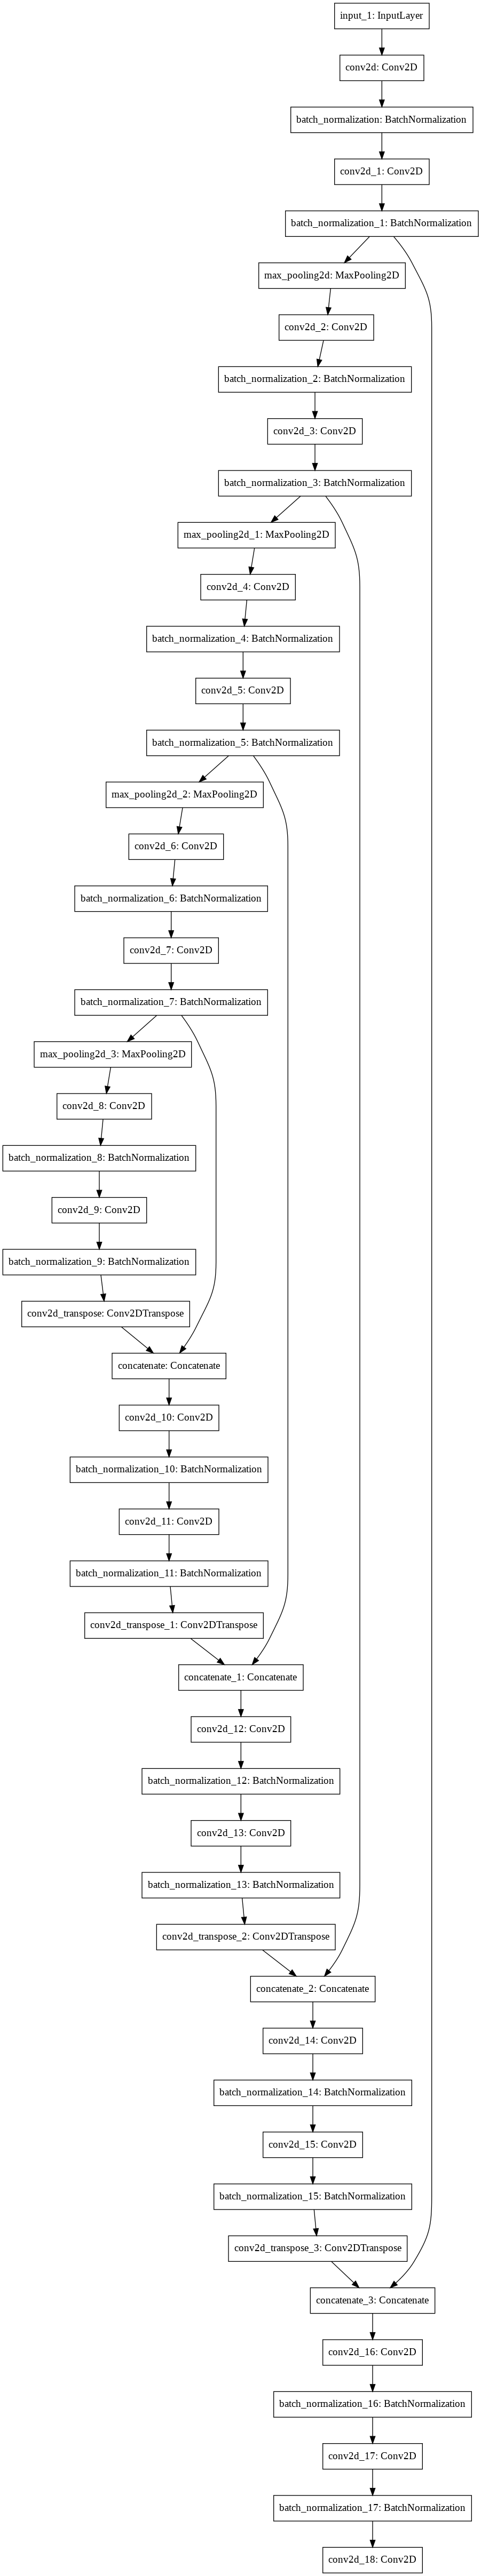

In [6]:
plot_model(model)

Se crean los distintos generadores de datos, los cuales nos van a permitir realizar el _data augmentation_ . En esta práctica, es aun más necesario recurrir a esta técnica ya que solo se disponen de 30 imágenes para entrenar el modelo, a diferencia de las 2000 de la anterior. 

En este ejercicio, el _data augmentation_ presenta una complicación. Las transformaciones deben realizarse tanto sobre la imagen original como sobre su máscara binaria. Para ello va a utilizarse el parámetro _seed_. 

In [14]:
# we create two instances with the same arguments 
data_gen_args = dict(featurewise_center=True,
                     featurewise_std_normalization=True,
                     rotation_range=90.,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2) 
image_datagen = ImageDataGenerator(**data_gen_args) 
mask_datagen = ImageDataGenerator(**data_gen_args)


seed = 1 # Para alterar tanto la imagen como su máscara

image_generator = image_datagen.flow_from_directory(
    '/content/data_unet/train/imgs',
    target_size=(512, 512),
    color_mode = 'grayscale', #imágenes en escala de grises -> un solo canal
    batch_size=10,
    class_mode=None,
    seed=seed)

mask_generator = mask_datagen.flow_from_directory(
    '/content/data_unet/train/labels',
    target_size=(512, 512),
    color_mode = 'grayscale',
    batch_size=10,
    class_mode=None,
    seed=seed)

Found 30 images belonging to 1 classes.
Found 30 images belonging to 1 classes.


Esta función será el generador del modelo. Básicamente a cada llamada del entrenamiento devuelve un _batch_ de imágenes y sus respectivas máscaras. Cada pareja imagen-máscara habra sido sometida a las mismas transformaciones. En este caso se emplea _yield_ en lugar de _return_ ya que este primero no fuerza la salida de la función. 

In [10]:
def train_generator ():
  train_gen = zip (image_generator, mask_generator)

  for (x,y) in train_gen: 
    yield (x,y)

Se entrena el modelo. El número de _epochs_ y _batches_ por _epoch_ es relativamente bajo. Esto ha sido así ya que con estos valores se han obtenido resultados relativamente buenos en un tiempo reducido. 

In [15]:

history = model.fit_generator(generator = train_generator(), 
                    steps_per_epoch = 15, 
                    epochs = 50)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/50
15/15 [==============================] - 11s 532ms/step - loss: -78.9832 - accuracy: 0.4406
Epoch 2/50
15/15 [==============================] - 8s 537ms/step - loss: -206.9899 - accuracy: 0.5804
Epoch 3/50
15/15 [==============================] - 8s 540ms/step - loss: -265.7517 - accuracy: 0.6509
Epoch 4/50
15/15 [==============================] - 8s 541ms/step - loss: -325.8661 - accuracy: 0.6956
Epoch 5/50
15/15 [==============================] - 8s 541ms/step - loss: -373.0863 - accuracy: 0.7166
Epoch 6/50
15/15 [==============================] - 8s 541ms/step - loss: -423.3761 - accuracy: 0.7231
Epoch 7/50
15/15 [==============================] - 8s 536ms/step - loss: -475.8874 - accuracy: 0.7191
Epoch 8/50
15/15 [==============================] - 8s 534ms/step - loss: -529.0097 - accuracy: 0.7215
Epoch 9/50
15/15 [==============================] - 8s 534ms/step - loss: -583.1932 - accuracy: 0.7182
Epoch 10/50
15/15 [==============================] - 8s 541ms/step - loss

A continuación se dibujan unas gráficas que permiten observar el entrenamiento del modelo en términos de _accuracy_ y error. 

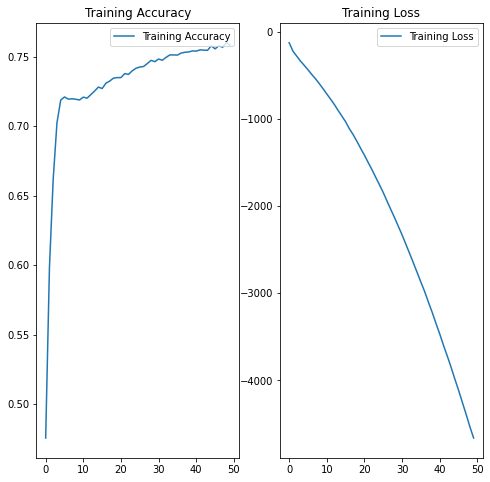

In [16]:
acc = history.history['accuracy']

loss = history.history['loss']

epochs = 50
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.legend(loc='upper right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()

En cuanto al _accuracy_ se observa como este sube bruscamente en las primeras _epochs_ y después tiende a a permanecer casi constante en valores entre 0.75 y 0.8. Este es uno de los motivos por los cuales tampoco se han escogido realizar más _epochs_ durante el entrenamiento, ya que la tendencia de la curva deja ver que no va a mejorar mucho el modelo en términos de _accuracy_. Además, podría existir el peligro de que si se sigue entrenando, se pueda caer en _overfitting_. La probabilidad de esto último aumenta al no haber incluido algunas medidas contra ello en el modelo, como por ejemplo _dropout_. 

Se procede a ordenar los datos del conjunto de test de una forma válida para realizar las posteriores predicciones. 

In [18]:
!mkdir /content/data_unet/test/test_imgs

In [19]:
!mv /content/data_unet/test/*.png  /content/data_unet/test/test_imgs/

Para realizar las predicciones, se crea un generador vacío, con todos los valores nulos, de tal forma que no se realice ningún tipo de transformación sobre las imágenes cargadas. 

Al principio se optó por cargar las imágenes una a una empleando la función de matplotlib _imread_ más un reajuste del tamaño de la imagen con tal de que este encajase en el modelo. Sin embargo este método daba problemas cuando se llamaba a _predict_. Al final se probó con el generador y funcionó correctamente.  

Nótese que en este caso se ha tenido que recurrir al parámetro _shuffle_ para que posteriormente se puedan mostrar correctamente los pares imagen-máscara. Este parámetro permite seleccionar _batches_ de imágenes de forma no aleatoria. 

In [34]:
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory('/content/data_unet/test',
                                                      target_size=(512, 512),
                                                      color_mode = 'grayscale',
                                                      batch_size=30,
                                                      class_mode=None,
                                                      shuffle = False, #para evitar que se ploteen imágenes distintas 
                                                      seed = 1)

Found 30 images belonging to 1 classes.


Se realiza la predicción. En este caso se realiza un solo _step_ ya que el _batch_size_ seleccionado es igual al número de imágenes de test disponibles. 

In [35]:
output = model.predict(test_generator, 
                       steps = 1)

Así pues en _output_ se tienen todas las máscaras. 

In [40]:
output.shape

(30, 512, 512, 2)

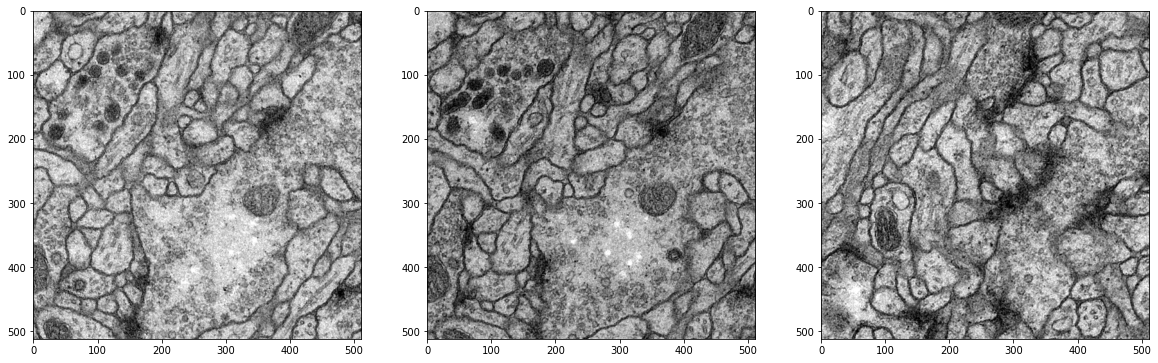

In [36]:
orig_test_img = next(test_generator)
fig, ax = plt.subplots(1,3, figsize=(20, 10))
ax[0].imshow(orig_test_img[0].reshape((512,512)), cmap='gray')
ax[1].imshow(orig_test_img[1].reshape((512,512)), cmap='gray')
ax[2].imshow(orig_test_img[2].reshape((512,512)), cmap='gray')


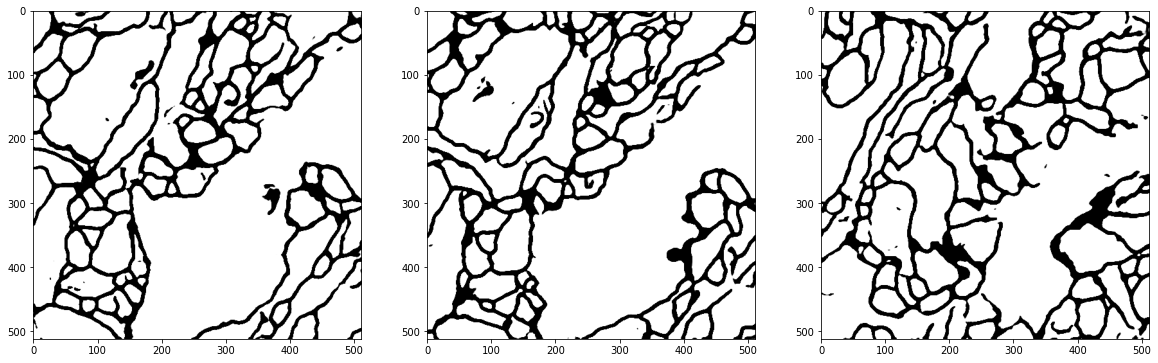

In [37]:
fig, ax = plt.subplots(1,3, figsize=(20, 10))
ax[0].imshow(output[0][:,:,0].reshape((512,512)), cmap='gray')
ax[1].imshow(output[1][:,:,0].reshape((512,512)), cmap='gray')
ax[2].imshow(output[2][:,:,0].reshape((512,512)), cmap='gray')

Puede apreciarse que los resultados son buenos, aunque mejorables. Especialmente esto se aprecia en algunos bordes inconexos. 

Por otra parte podría decirse que no existen indicios de _overfitting_. Así a ojo, podría decirse que el _accuracy_ de test ronda también el 75-80 %, al igual que en el conjunto de entrenamiento. 

Como posibles mejoras, existe la opción de entrenar la red con un mayor número de _epochs_. Por otro lado, podrías modificarse algunos parámetros internos, como el núemero de filtros empleados en cada una de las capas. Idealmente, lo mejor sería disponer de un mayor número de imágenes para entrenar. 